# Classificação de dígitos utilizando HOG e k-vizinhos

### 1. Pré-processamento dos dados

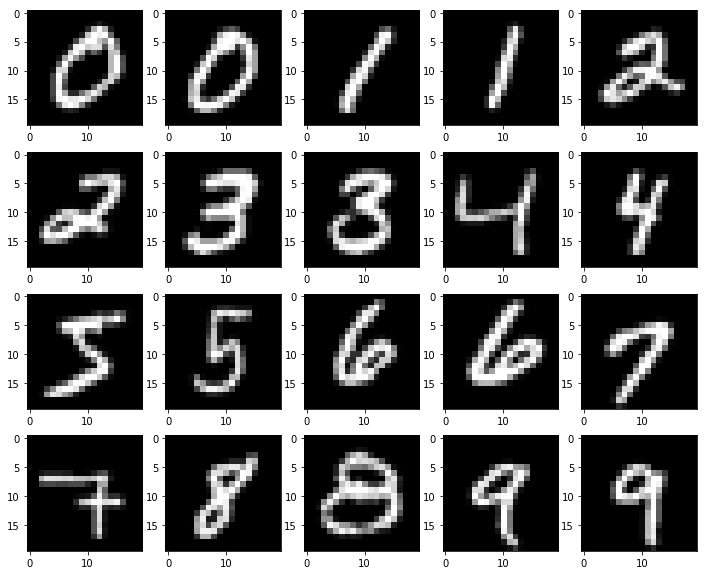

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lê imagem contendo 5000 dígitos, o parâmetro 0 indica que a imagem
# lida deve ser convertida para tons de cinza.
original_img = cv2.imread('digits.png', 0)
num_classes = 10
digit_size = 20               # Número de linhas e colunas das imagens
digits_per_class = 500

# Obtém número de dígitos nas linhas e colunas da imagem original
num_rows, num_cols = original_img.shape
num_rows_digits = int(num_rows/digit_size)
num_cols_digits = int(num_cols/digit_size)

# Gera lista de imagens contendo os dígitos separados da imagem lida acima
all_digit_images = []
for i in range(num_rows_digits):
    for j in range(num_cols_digits):
        digit_img = original_img[i*digit_size:(i+1)*digit_size, 
                                 j*digit_size:(j+1)*digit_size]
        all_digit_images.append(digit_img)
        
# Mostra 2 dígitos de cada classe
k = 0
plt.figure(figsize=(12,10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(all_digit_images[k], 'gray')
    k += digits_per_class//2

In [2]:
# Divide conjunto de dados em treinamento e teste
split_amount = digits_per_class//2
train_imgs = []
test_imgs = []
for i in range(num_classes):
    class_images = all_digit_images[i*digits_per_class:(i+1)*digits_per_class]
    train_imgs.extend(class_images[:split_amount])
    test_imgs.extend(class_images[split_amount:])

### 2. Criação do descritor HOG e aplicação nas imagens de treinamento

In [3]:
# Inicialização do descritor HOG      
winSize = (20,20)         # Tamanho da imagem
blockSize = (10,10)       # Tamanho do bloco (quadrado azul nos slides)
blockStride = (5,5)       # Quantos pixels o bloco é transladado 
cellSize = (5,5)          # Tamanho da célula
nbins = 9                 # Número de caixas no histograma
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
# Com os parâmetros utilizados, cada bloco possui 4 células. Cada célula define
# um histograma de 9 caixas. Adicionalmente, como utilizamos blockStride igual a 5
# teremos 9 blocos ao longo da imagem. Portanto, teremos 
# 9 (blocos) * 4 (células por bloco) * 9 (valores por célula) = 324 atributos
# associados com cada imagem

# Calcula atributos HOG para cada imagem, e transforma o resultado em um array
# numpy para utilizar os dados com o OpenCV
hog_data = []
for img in train_imgs:
    hog_data.append(hog.compute(img)[:,0])
train_data = np.array(hog_data)

# Define o índice da classe para cada imagem
labels = []
for class_index in range(num_classes):
    for i in range(digits_per_class//2):
        labels.append([class_index])
labels = np.array(labels)

# Imprime os atributos HOG para a primeia imagem
print(train_data[0].tolist())

[0.00041878136107698083, 0.005836093332618475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012891244841739535, 0.03819442167878151, 0.275068998336792, 0.1646546721458435, 0.005633712746202946, 0.0, 0.0, 0.0, 0.0, 0.007723179645836353, 0.0052267443388700485, 0.22998246550559998, 0.4504990577697754, 0.04566888138651848, 0.0014041445683687925, 0.0, 0.0, 0.0, 0.0005156496772542596, 0.04417889937758446, 0.5419937372207642, 0.5419937372207642, 0.16827328503131866, 0.12023625522851944, 0.0, 0.0, 0.0, 0.005793347489088774, 0.14033949375152588, 0.26243290305137634, 0.1249639168381691, 0.007604733109474182, 0.0, 0.0, 0.0, 0.0, 0.012975906953215599, 0.345798522233963, 0.2704853415489197, 0.07543507218360901, 0.005069821607321501, 0.0, 0.0018360762624070048, 0.014719706028699875, 0.02024044655263424, 0.2018786072731018, 0.1334684044122696, 0.345798522233963, 0.345798522233963, 0.09461050480604172, 0.05765862762928009, 0.0, 0.0, 0.0, 0.011005820706486702, 0.345798522233963, 0.345798522233963, 0.2821328938007

### 3. "Treinamento" do classificador k-vizinhos

O classificador k-vizinhos é conhecido como lazy, pois na verdade não é feito nenhum cálculo durante o treinamento. A parte mais pesada computacionalmente é feita somente no momento da classificação. 

Outros classificadores como o SVM fazem os cálculos mais pesados no momento do treinamento e são muito mais rápidos do que o k-vizinhos no momento da classificação.

In [4]:
# Cria classificador
knn = cv2.ml.KNearest_create()

# "Treina" o classificador. O segundo argumento indica que cada 
# objeto (imagem) corresponde a uma linha da matriz
knn.train(train_data, cv2.ml.ROW_SAMPLE, labels)

True

### 4. Teste da acurácia do classificador

Agora, testamos como o nosso sistema lida com imagens que não foram utilizadas no treinamento.

In [5]:
hog_data = []
for img in test_imgs:
    hog_data.append(hog.compute(img)[:,0])
test_data = np.array(hog_data)

# Classifica as imagens utilizando os 3 vizinhos mais próximos. result é
# um array indicando o índice da classe de cada imagem de teste, neighbors
# é uma matriz na qual cada linha i indica a classe dos k pontos mais próximos
# ao ponto i e dist é uma matriz na qual cada linha i indica a distância entre
# o ponto i e os k vizinhos mais próximos
ret, result, neighbors, dist = knn.findNearest(test_data,k=3)

# Calcula porcentagem de acerto, dada pelo número de valores que são iguais em result
# e responses dividido pelo número de imagens de teste. Aqui podemos utilizar a variável
# labels criada anteriormente porque o conjunto de testes possui o mesmo número de imagens
# que o conjunto de treinamento.
mask = result==labels
num_equal = np.sum(mask)
print("Accurácia: {}%".format(100*num_equal/len(result)))

Accurácia: 96.72%
